# GSTools: The Python toolbox for your geo-statistical project!

<p align="center">
<img src="https://raw.githubusercontent.com/GeoStat-Framework/GSTools/master/docs/source/pics/gstools.png" alt="GSTools-LOGO" width="251px"/>
</p>

##  Sebastian Müller, Lennart Schüler, Alraune Zech, Sabine Attinger and Falk Heße
*To navigate through the presentation, use the arrows in the lower right corner or your arrow-keys (*__*right*__ *&rarr; next section;* __*down*__ *&rarr; go through current section)*

**GSTools** is embedded in the GitHub Organiztaion **GeoStat-Framework**: https://github.com/GeoStat-Framework/GSTools

## Purpose

<img
align="right"
width="300" 
src="https://raw.githubusercontent.com/GeoStat-Framework/GeoStat-Framework.github.io/master/img/GS_globe.png" 
alt=""/>

GSTools provides tools for various purposes:
- simple, ordinary, universal, <br>
  external drift and detrended kriging
- random (vector) field generation
- conditioned field generation
- arbitrary dimensions & geographical coordinates
- (automatted) variogram estimation and fitting
- directional variogram estimation and modelling
- data normalization and transformation
- many covariance models
- metric spatio-temporal modelling
- plotting and exporting routines

<img
align="right"
width="300" 
src="https://raw.githubusercontent.com/GeoStat-Framework/GSTools/master/docs/source/pics/demonstrator.png" 
alt=""/>
## Installation

You can install GSTools via `pip` *or* `conda`:

`pip/conda install gstools`

In [1]:
import warnings
warnings.filterwarnings('ignore')

# 1. Random Field Generation

The original main feature of GSTools is the spatial random field generator [`SRF`](https://geostat-framework.readthedocs.io/projects/gstools/en/stable/field.html#gstools.field.SRF), which can generate random fields following a given covariance model. These can be used for hypothesis testing and simulations.

## A Very Simple Example

A spatial random field with an isotropic Gaussian covariance model.

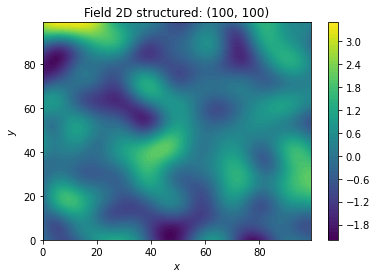

In [2]:
import gstools as gs
# 100x100 field
x = y = range(100)
model = gs.Gaussian(dim=2, var=1, len_scale=10)
srf = gs.SRF(model, seed=20170519)
field = srf.structured([x, y])
ax = srf.plot()

## Fancier Fields
Using an anisotropic Matern covariance model.

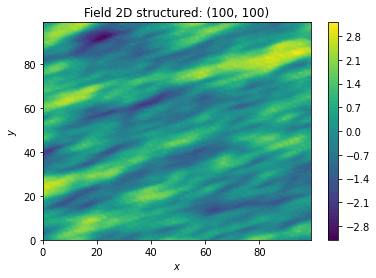

In [3]:
import numpy as np
x = y = np.arange(100)
model = gs.Matern(dim=2, var=1, len_scale=[12.0, 3.0], angles=np.deg2rad(22.5))
srf = gs.SRF(model, seed=20170519)
srf.structured([x, y])
ax = srf.plot()

# 2. Kriging

The following kriging methods are provided within the submodule `gstools.krige`.

Name | Description | Properties
--- | --- | ---
`Krige` | Swiss-Army-Knife for kriging | Including all present methods
`Simple` | Simple kriging | Given mean
`Ordinary` | Ordinary kriging | Estimated mean (unbiased condition)
`Universal` | Universal kriging | Functional drift
`ExtDrift` | External drift kriging (EDK) | Given drift
`Detrended` | Detrended simple kriging | For regression kriging

## Interpolating spatial data
GSTools provides routines to automatically normalize data, fit a variogram model and interpolate the data with kriging.

In [4]:
import numpy as np
import gstools as gs
# temperature station data from DWD
lat = np.array([52.9336, 48.6159, 52.4853, 50.7446, 52.9437, 53.8633, 47.8342,
                51.0881, 48.406 , 49.7273, 49.4691, 48.0197, 50.4237, 53.0316,
                53.8412, 54.6792, 49.9694, 51.3745, 47.8774, 50.5908])
lon = np.array([ 8.237 , 13.0506,  7.9126,  9.345 , 12.8518,  8.1275, 10.8667,
                12.9326, 11.3117,  8.1164, 11.8546, 12.2925,  7.4202, 13.9908,
                13.6846, 13.4343,  9.9114, 11.292 , 11.3643, 12.7139])
temp = np.array([15.7, 13.9, 15.1, 17. , 21.9, 11.9, 11.4, 17.2, 12.9, 17.2, 13.4,
                 13.9, 18.1, 21.3, 21.3, 17.4, 18.6, 20.2, 12.7, 15.8])
# output grid
grid_lat = np.linspace(47, 55)
grid_lon = np.linspace( 7, 15)

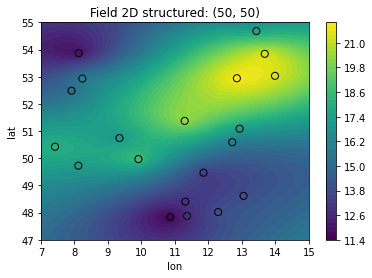

In [5]:
model = gs.Spherical(latlon=True, rescale=gs.EARTH_RADIUS)
krige = gs.krige.Ordinary(
    model, cond_pos=[lat, lon], cond_val=temp, fit_variogram=True)
field = krige.structured([grid_lat, grid_lon])
ax = krige.plot()
# plotting lat on y-axis and lon on x-axis
scat = ax.scatter(lon, lat, 50, c=temp, edgecolors="k")

In [6]:
krige.model

Spherical(latlon=True, var=9.91, len_scale=4.7e+02, nugget=1.78e-15, rescale=6.37e+03)

# 3. Conditioned Fields

Kriged fields tend to approach the field mean with increasing distance to observations. GSTools provides a combination of the Randomization Method and the Kriging routines to provided conditioned random fields.

## Conditioning with Ordinary Kriging

Here we use ordinary kriging in 1D (for plotting reasons) with 5 given observations/conditions, to generate an ensemble of conditioned random fields.

In [7]:
import matplotlib.pyplot as plt
# condtions
cond_pos = [0.3, 1.9, 1.1, 3.3, 4.7]
cond_val = [0.47, 0.56, 0.74, 1.47, 1.74]
gridx = np.linspace(0.0, 15.0, 151)

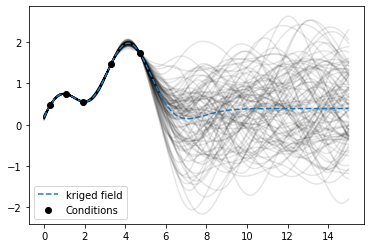

In [8]:
model = gs.Gaussian(dim=1, var=0.5, len_scale=2)
krige = gs.Krige(model, cond_pos, cond_val)
cond_srf = gs.CondSRF(krige)
fields = []
for i in range(100):
    fields.append(cond_srf(gridx, seed=i))
    plt.plot(gridx, fields[i], color="k", alpha=0.1)
plt.plot(gridx, cond_srf.krige.field, linestyle="dashed", label="kriged field")
plt.scatter(cond_pos, cond_val, color="k", zorder=10, label="Conditions")
plt.legend()
plt.show()

# 4. Normalization
When dealing with real-world data, one can’t assume it to be normal distributed. In fact, many properties are modeled by applying different transformations, for example conductivity is often assumed to be log-normal or precipitation is transformed using the famous box-cox power transformation.

## Interpolating non-normal data
Here we generate synthetic data, sample from it and try to reconstruct the field.

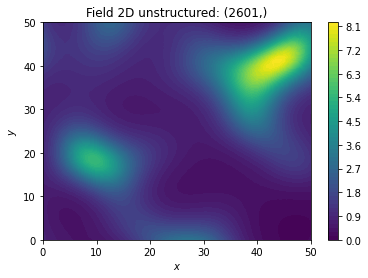

In [9]:
import numpy as np
import gstools as gs
import matplotlib.pyplot as plt
# structured field with edge length of 50
x = y = range(51)
pos = gs.generate_grid([x, y])
model = gs.Gaussian(dim=2, var=1, len_scale=10)
srf = gs.SRF(model, seed=20170519, normalizer=gs.normalizer.LogNormal)
# generate the original field
field = srf(pos)
ax = srf.plot()

Now we sample 60 points and set the conditioning points and values.

In [10]:
ids = np.arange(field.size)
samples = np.random.RandomState(20210201).choice(ids, size=60, replace=False)
# sample conditioning points from generated field
cond_pos = pos[:, samples]
cond_val = field[samples]

In [11]:
krige = gs.krige.Ordinary(
    model=gs.Stable(dim=2),
    cond_pos=cond_pos, cond_val=cond_val,
    normalizer=gs.normalizer.BoxCox,
    fit_normalizer=True,
    fit_variogram=True,
)
print(krige.model)
print(krige.normalizer)

Stable(dim=2, var=0.576, len_scale=8.85, nugget=0.00682, alpha=2.0)
BoxCox(lmbda=-0.0754)


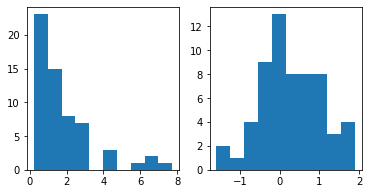

In [12]:
fig, axs = plt.subplots(1, 2, figsize=[6, 3])
hist_raw = axs[0].hist(cond_val)
hist_nrm = axs[1].hist(krige.normalizer.normalize(cond_val))

In [13]:
field = krige(pos, return_var=False)

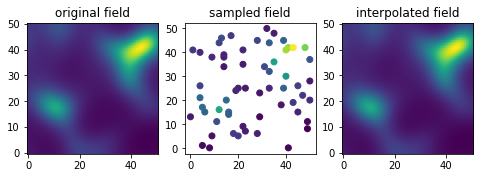

In [14]:
fig, ax = plt.subplots(1, 3, figsize=[8, 3])
ax[0].imshow(field.reshape(len(x), len(y)).T, origin="lower")
ax[1].scatter(*cond_pos, c=cond_val)
ax[2].imshow(krige.field.reshape(len(x), len(y)).T, origin="lower")
# titles
ax[0].set_title("original field")
ax[1].set_title("sampled field")
ax[2].set_title("interpolated field")
ax[1].set_aspect("equal")

# Final words

This was a brief glimpse on what `GSTools` (https://github.com/GeoStat-Framework/GSTools) is capable of.

The package is included in an infrastructure of Python packages called **"GeoStat Framework"** (https://geostat-framework.org/)

## Interfaces

GSTools provides interfaces to the follwing packages:
- [PyVista](https://github.com/pyvista/pyvista)
- [PyKrige](https://github.com/GeoStat-Framework/PyKrige)
- [meshio](https://github.com/nschloe/meshio)
- [ogs5py](https://github.com/GeoStat-Framework/ogs5py)
- [scikit-gstat](https://github.com/mmaelicke/scikit-gstat)
- [pyevtk](https://github.com/pyscience-projects/pyevtk)

You can contact us via [mail](mailto:info@geostat-framework.org) or on [Gitter](https://gitter.im/GeoStat-Framework/GSTools) or on [GitHub Discussions](https://github.com/GeoStat-Framework/GSTools/discussions) or maybe on a **slack channel** in *swung*?!